In [1]:
import networkx as nx
import numpy as np
from itertools import product
import scipy.optimize as opt
import numpy.random as rd
import random

from utils import output_image, distance

SEED = 342235

In [18]:
class GeneticAlgortihm:
    def __init__(
        self,
        width,
        height,
        num_poi,
        num_cs,
        num_new_cs,
        pop_size=100,
        mutation_rate=0.1,
        crossover_rate=0.5,
        generations=1000,
        seed=None,
    ):
        # Set up parameters
        self.width = width
        self.height = height
        self.num_new_cs = num_new_cs
        self.num_poi = num_poi
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.population = []
        self.best_solution = None
        self.best_fitness = np.inf
        self.best_generation = 0
        self.seed = seed

        # Set up scenario
        self.graph = None
        self.pois = None
        self.charging_stations = None
        self.potential_new_cs_nodes = None
        self.set_up_scenario(width, height, num_poi, num_cs)

    def set_up_scenario(self, width, height, num_poi, num_cs):
        """Build scenario set up with specified parameters.

        Args:
            w (int): Width of grid
            h (int): Height of grid
            num_poi (int): Number of points of interest
            num_cs (int): Number of existing charging stations

        Returns:
            G (networkx graph): Grid graph of size w by h
            pois (list of tuples of ints): A fixed set of points of interest
            charging_stations (list of tuples of ints):
                Set of current charging locations
            potential_new_cs_nodes (list of tuples of ints):
                Potential new charging locations
        """
        random.seed(self.seed)

        # Create a grid graph
        self.graph = nx.grid_2d_graph(width, height)
        nodes = list(self.graph.nodes)

        # Identify a fixed set of points of interest and charging locations
        self.pois = random.sample(nodes, k=num_poi)
        self.charging_stations = random.sample(nodes, k=num_cs)

        # Identify potential new charging locations
        self.potential_new_cs_nodes = list(self.graph.nodes() - self.charging_stations)
        #self.potential_new_cs_nodes = [list(node) for node in potential_nodes]

    def init_population(self):
        """
        Initialize the population with random paths.
        """
        self.population = [
            random.choices(self.potential_new_cs_nodes, k=(self.num_new_cs))
            for _ in range(self.pop_size)
        ]

    def fitness(self, new_charging_nodes):
        """
        Calculate the fitness of a path.

        Args:
            new_charging_nodes (list): List of nodes representing the path.

        Returns:
            float: The fitness of the path.
        """
        min_dist = np.zeros(self.num_poi)
        for j, p in enumerate(self.pois):
            min_dist[j] = min(
                distance(p, c) for c in new_charging_nodes + self.charging_stations
            )
        return min_dist.sum()

    def tournament_selection(self, k=2):
        """
        Select the best individual from a random sample of the population.

        Args:
            k (int, optional): Number of individuals to sample. Defaults to 2.

        Returns:
            list: The best individual.
        """
        selected = random.choices(self.population, k=k)
        return min(selected, key=self.fitness)

    def crossover(self, parent1, parent2):
        """
        Perform a crossover operation on two parents to produce a child.

        Args:
            parent1 (list): First parent.
            parent2 (list): Second parent.

        Returns:
            list: The child produced by crossover.
        """
        child = []
        for i in range(self.num_new_cs):
            if random.random() < 0.5:
                child.append(parent1[i])
            else:
                child.append(parent2[i])

        # Ensure uniqueness of genes (nodes) in the child
        unique_child = np.unique(child, axis=0).tolist()

        # Fill in the remaining genes from either parent to maintain the correct length
        parent_combined = parent1 + parent2
        for node in parent_combined:
            if len(unique_child) < self.num_new_cs and node not in unique_child:
                unique_child.append(node)

        return unique_child

    def mutate(self, path):
        """
        Mutate a path by swapping two elements with a given probability.

        Args:
            path (list): The path to mutate.
        
        Returns:
            list: The mutated path.
        """
        if random.random() < self.mutation_rate:
            mutated_path = []
            for node in path:
                if random.random() < self.mutation_rate:
                    # Mutate x and y coordinates separately
                    new_x = node[0] + random.randint(-1, 1)
                    new_y = node[1] + random.randint(-1, 1)
                    # Ensure new coordinates are within grid bounds
                    new_x = max(0, min(new_x, self.width - 1))
                    new_y = max(0, min(new_y, self.height - 1))
                    mutated_path.append((new_x, new_y))
                else:
                    mutated_path.append(node)
            return mutated_path
        return path

    def run(self):
        """
        Run the genetic algorithm to solve the problem.
        """
        # Initialize the population
        self.init_population()
        for gen in range(self.generations):
            new_population = []
            for _ in range(self.pop_size):
                parent1 = self.tournament_selection()
                if random.random() < self.crossover_rate:
                    parent2 = self.tournament_selection()
                    child = self.crossover(parent1, parent2)
                else:
                    child = parent1
                child = self.mutate(child)
                new_population.append(child)
            self.population = new_population
            for path in self.population:
                fit = self.fitness(path)
                if fit < self.best_fitness:
                    self.best_fitness = fit
                    self.best_solution = path
                    self.best_generation = gen

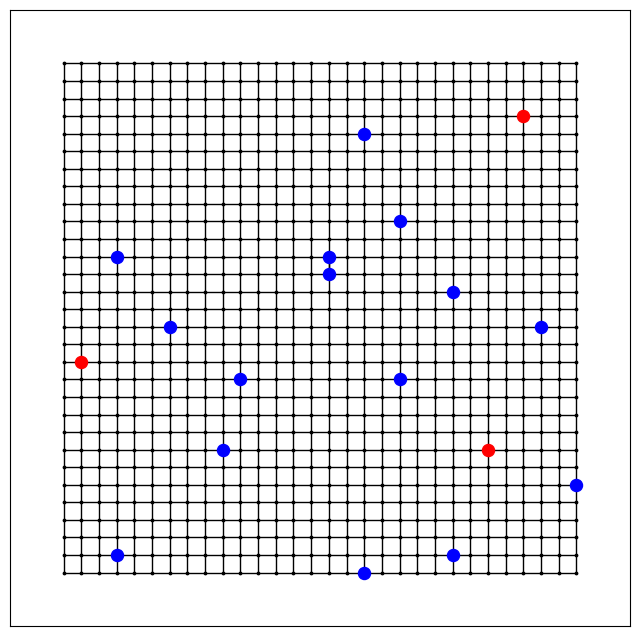

In [25]:
WIDTH = 30
HEIGHT = 30
POI = 15
CHARGERS = 3
NEW_CHARGERS = 4

gen = GeneticAlgortihm(WIDTH, HEIGHT, POI, CHARGERS, NEW_CHARGERS, seed=None)
gen.init_population()
output_image(gen.graph, gen.pois, gen.charging_stations)

In [26]:
gen.run()
gen.best_solution
gen.best_fitness

288.0

Best Generation: 43


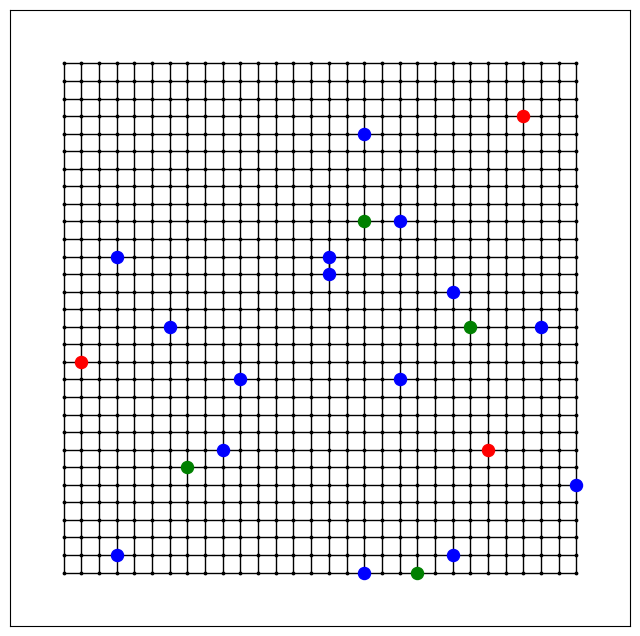

In [27]:
print("Best Generation:", gen.best_generation)
output_image(gen.graph, gen.pois, gen.charging_stations, gen.best_solution)